In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
%matplotlib inline

dash = pd.read_csv('/home/ml/datasets/DASH60.csv',delimiter=',', parse_dates=[['Date', 'Time']])
dash.head(1)

,Date_Time,Open,Max,Min,Close,Volume
0,2017-09-08 13:00:00,361.0,362.79,335.93,335.93,185


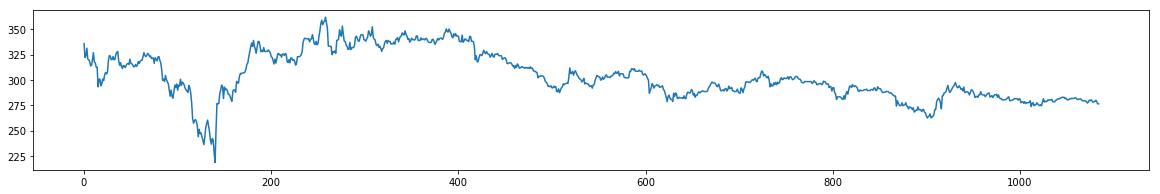

In [2]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="Close")

In [3]:
def get_privot_dot(price_close, min_value,max_value):
    privot_dot = (price_close + max_value + min_value)/3
    return privot_dot  

In [4]:
def get_resistors(privot_dot,min_value,max_value):
    r1 = 2*privot_dot-min_value
    r2 = privot_dot+max_value-min_value
    r3 = 2*(privot_dot-min_value)+max_value
    result = pd.DataFrame({'R1': r1, 'R2': r2, 'R3': r3})
    return result

In [5]:
def get_supports(privot_dot,min_value,max_value):
    s1 = 2*privot_dot-max_value
    s2 = privot_dot-max_value-min_value
    s3 = min_value-(2*(max_value-privot_dot))
    result = pd.DataFrame({'S1': s1, 'S2': s2, 'S3': s3})
    return result

In [6]:
def get_bollinger_bands(price_close, window_size, num_of_std):
    rolling_mean = price_close.rolling(window=window_size,min_periods=1).mean()
    rolling_std= price_close.rolling(window=window_size,min_periods=1).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    result = pd.DataFrame({'BB_Mean': rolling_mean, 'BB_Upper': upper_band, 'BB_Lower': lower_band})
    return result

In [7]:
def get_moving_average_convergence(price_close, nslow=26, nfast=12):
    emaslow = price_close.ewm(span=nslow, min_periods=1).mean()
    emafast = price_close.ewm(span=nfast, min_periods=1).mean()
    macd = emafast-emaslow
    result = pd.DataFrame({'MACD': macd, 'EMA_26': emaslow, 'EMA_12': emafast})
    return result

In [32]:
def get_relative_stength_index(up_array, down_array,window_size=14):
    up_array[up_array < 0] = 0
    down_array[down_array > 0] = 0

    rolUp = up_array.rolling(window=window_size,min_periods=1).mean()
    rolDown = down_array.rolling(window=window_size,min_periods=1).mean().abs()
    rs = rolUp / rolDown
    avgUp = rolUp/window_size
    avgDown = rolDown/window_size
    rsi = 100*((avgUp)/(avgUp+avgDown))
    
    result = pd.DataFrame({'RSI': rsi})
    return result

In [33]:
def get_true_range(price_close, price_max, price_min):
    tr1 = price_max-dash['Min']
    tr2 = price_max-price_close.shift(-1)
    tr2 = tr2.abs()
    tr3 = price_min-price_close.shift(-1)
    tr3 = tr3.abs()

    TR = pd.DataFrame({'TR1': tr1, 'TR2': tr2, 'TR3': tr3,})
    TR = TR[['TR1', 'TR2', 'TR3']].max(axis=1)
    result = pd.DataFrame({'TR': TR}) 
    
    return result

In [34]:
def get_average_true_range(tr, window_size=14):
    rsi = tr.ewm(span=window_size, min_periods=1).mean()
    result = pd.DataFrame({'ATR': rsi})
    return result

In [35]:
def get_parabolic_stop_and_reversal(s, af=0.02, amax=0.2):
    high, low = s.Max, s.Min

    sig0, xpt0, af0 = True, high[0], af
    sar = [low[0] - (high - low).std()]

    for i in range(1, len(s)):
        sig1, xpt1, af1 = sig0, xpt0, af0

        lmin = min(low[i - 1], low[i])
        lmax = max(high[i - 1], high[i])

        if sig1:
            sig0 = low[i] > sar[-1]
            xpt0 = max(lmax, xpt1)
        else:
            sig0 = high[i] >= sar[-1]
            xpt0 = min(lmin, xpt1)

        if sig0 == sig1:
            sari = sar[-1] + (xpt1 - sar[-1])*af1
            af0 = min(amax, af1 + af)

            if sig0:
                af0 = af0 if xpt0 > xpt1 else af1
                sari = min(sari, lmin)
            else:
                af0 = af0 if xpt0 < xpt1 else af1
                sari = max(sari, lmax)
        else:
            af0 = af
            sari = xpt0

        sar.append(sari)
    
    result = pd.DataFrame({'PSAR': sar})
    return result

In [36]:
get_moving_average_convergence(dash['Close']).tail(1)

,EMA_12,EMA_26,MACD
1084,278.459343,279.22259,-0.763246


In [37]:
dash['SMA14'] = dash['Close'].rolling(window=14,min_periods=1).mean()
dash['SMA30'] = dash['Close'].rolling(window=30,min_periods=1).mean()
dash['EMA14'] = dash['Close'].ewm(span=14,min_periods=1).mean()
dash['EMA30'] = dash['Close'].ewm(span=30,min_periods=1).mean()

In [38]:
num_of_std = dash['Close'].std()
get_bollinger_bands(dash['Close'],20,num_of_std).head(5)

,BB_Lower,BB_Mean,BB_Upper
0,NaN,335.9300,NaN
1,101.142356,329.0450,556.947644
2,151.648753,327.3200,502.991247
3,177.269220,328.3325,479.395780
4,173.684598,326.8120,479.939402


In [39]:
min_values = dash['Min']
max_values = dash['Max']
close_values = dash['Close']
privot_dots = get_privot_dot(close_values,min_values,max_values)
dash['Privot_Dot'] = privot_dots

get_supports(privot_dots,min_values,max_values).tail(3)

,S1,S2,S3
1082,278.400000,-279.600000,277.200000
1083,275.613333,-277.913333,273.133333
1084,276.500000,-276.500000,276.500000


In [40]:
get_resistors(privot_dots,min_values,max_values).tail(3)

,R1,R2,R3
1082,279.600000,280.400000,280.800000
1083,278.093333,279.686667,280.573333
1084,276.500000,276.500000,276.500000


In [41]:
diff = np.ediff1d(dash[['Close']])
diff_df = pd.DataFrame([dash.Close,np.ediff1d(dash[['Close']])], dtype=float)
diff_array = diff_df.values[1]
dash['Diff'] = diff_array

In [42]:
dUp, dDown = dash['Diff'].copy(), dash['Diff'].copy()
get_relative_stength_index(dUp,dDown).head()

,RSI
0,0.000000
1,11.046512
2,40.078329
3,27.394408
4,26.812227


In [43]:
get_true_range(dash['Close'], dash['Max'], dash['Min']).head()

,TR
0,40.63
1,42.27
2,24.17
3,15.17
4,11.54


In [44]:
get_parabolic_stop_and_reversal(dash).head()

,PSAR
0,332.475291
1,362.790000
2,362.790000
3,360.024800
4,357.370208


In [48]:
dash['TR'] = get_true_range(dash['Close'], dash['Max'], dash['Min'])

In [49]:
resitor_df = get_resistors(privot_dots,min_values,max_values)
support_df = get_supports(privot_dots,min_values,max_values)
bollinger_df = get_bollinger_bands(dash['Close'],20,num_of_std)
macd_df = get_moving_average_convergence(dash['Close'])
rsi_df = get_relative_stength_index(dUp,dDown)
tr_df = get_true_range(dash['Close'], dash['Max'], dash['Min'])
atr_df = get_average_true_range(dash['TR'])
psar_df = get_parabolic_stop_and_reversal(dash) 

dash_raw = dash.copy()

dash = pd.concat([dash_raw, resitor_df, support_df, bollinger_df, macd_df, rsi_df,tr_df, atr_df,psar_df], axis=1)

In [50]:
dash['Pct_Change'] = dash['Close'].pct_change()

In [51]:
dash['Direction'] = np.sign(dash['Close'].pct_change())

In [52]:
dash.head()

,Date_Time,Open,Max,Min,Close,Volume,SMA14,SMA30,EMA14,EMA30,...,BB_Upper,EMA_12,EMA_26,MACD,RSI,TR,ATR,PSAR,Pct_Change,Direction
0,2017-09-08 13:00:00,361.00,362.79,335.93,335.93,185,335.9300,335.9300,335.930000,335.930000,...,NaN,335.930000,335.930000,0.000000,0.000000,40.63,40.630000,332.475291,NaN,NaN
1,2017-09-08 14:00:00,335.93,335.93,293.66,322.16,274,329.0450,329.0450,328.553214,328.815500,...,556.947644,328.471250,328.780192,-0.308942,11.046512,42.27,41.508571,362.790000,-0.040991,-1.0
2,2017-09-08 15:00:00,322.16,326.39,307.20,323.87,241,327.3200,327.3200,326.764211,327.055920,...,502.991247,326.675381,327.016008,-0.340627,40.078329,24.17,34.885178,362.790000,0.005308,1.0
3,2017-09-08 16:00:00,324.00,335.90,324.00,331.37,137,328.3325,328.3325,328.173251,328.244606,...,479.395780,328.157289,328.233194,-0.075905,27.394408,15.17,28.853749,360.024800,0.023157,1.0
4,2017-09-08 17:00:00,331.37,331.54,320.73,320.73,121,326.8120,326.8120,326.231319,326.534851,...,479.939402,326.139321,326.493172,-0.353851,26.812227,11.54,24.336618,357.370208,-0.032109,-1.0


In [53]:
dash.isnull().sum()

Date_Time     0
Open          0
Max           0
Min           0
Close         0
Volume        0
SMA14         0
SMA30         0
EMA14         0
EMA30         0
Privot_Dot    0
Diff          1
TR            0
R1            0
R2            0
R3            0
S1            0
S2            0
S3            0
BB_Lower      1
BB_Mean       0
BB_Upper      1
EMA_12        0
EMA_26        0
MACD          0
RSI           0
TR            0
ATR           0
PSAR          0
Pct_Change    1
Direction     1
dtype: int64

In [58]:
dash = dash.dropna()

In [59]:
dash.isnull().sum()

Date_Time     0
Open          0
Max           0
Min           0
Close         0
Volume        0
SMA14         0
SMA30         0
EMA14         0
EMA30         0
Privot_Dot    0
Diff          0
TR            0
R1            0
R2            0
R3            0
S1            0
S2            0
S3            0
BB_Lower      0
BB_Mean       0
BB_Upper      0
EMA_12        0
EMA_26        0
MACD          0
RSI           0
TR            0
ATR           0
PSAR          0
Pct_Change    0
Direction     0
dtype: int64

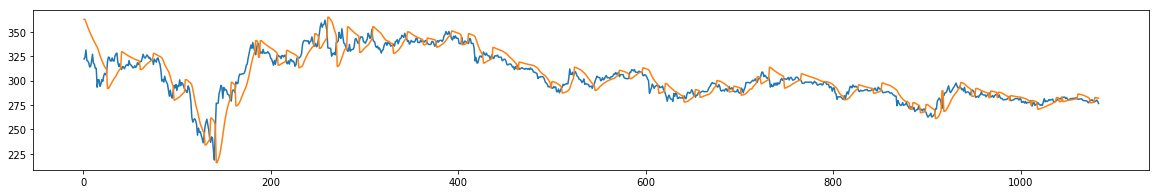

In [62]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="Close")
plt.plot(dash.index, dash['PSAR'] , label="PSAR")

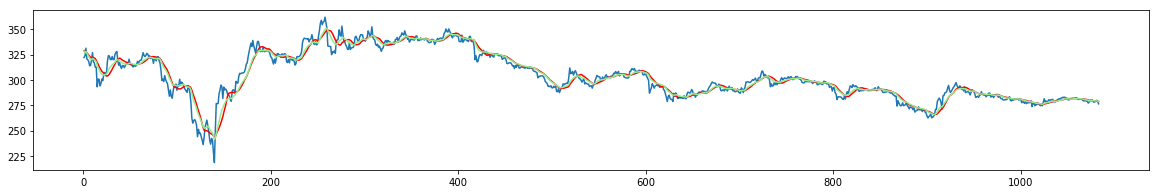

In [63]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="close")
plt.plot(dash.index, dash['SMA14'] , label="SMA14", c='red')
plt.plot(dash.index, dash['EMA14'] , label="SMA30",c='lightgreen')

In [73]:
dash.columns[1:30]

Index(['Open', 'Max', 'Min', 'Close', 'Volume', 'SMA14', 'SMA30', 'EMA14',
       'EMA30', 'Privot_Dot', 'Diff', 'TR', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3',
       'BB_Lower', 'BB_Mean', 'BB_Upper', 'EMA_12', 'EMA_26', 'MACD', 'RSI',
       'TR', 'ATR', 'PSAR', 'Pct_Change'],
      dtype='object')

In [65]:
dash.head()

,Date_Time,Open,Max,Min,Close,Volume,SMA14,SMA30,EMA14,EMA30,...,BB_Upper,EMA_12,EMA_26,MACD,RSI,TR,ATR,PSAR,Pct_Change,Direction
1,2017-09-08 14:00:00,335.93,335.93,293.66,322.16,274,329.045000,329.045000,328.553214,328.815500,...,556.947644,328.471250,328.780192,-0.308942,11.046512,42.27,41.508571,362.790000,-0.040991,-1.0
2,2017-09-08 15:00:00,322.16,326.39,307.20,323.87,241,327.320000,327.320000,326.764211,327.055920,...,502.991247,326.675381,327.016008,-0.340627,40.078329,24.17,34.885178,362.790000,0.005308,1.0
3,2017-09-08 16:00:00,324.00,335.90,324.00,331.37,137,328.332500,328.332500,328.173251,328.244606,...,479.395780,328.157289,328.233194,-0.075905,27.394408,15.17,28.853749,360.024800,0.023157,1.0
4,2017-09-08 17:00:00,331.37,331.54,320.73,320.73,121,326.812000,326.812000,326.231319,326.534851,...,479.939402,326.139321,326.493172,-0.353851,26.812227,11.54,24.336618,357.370208,-0.032109,-1.0
5,2017-09-08 18:00:00,320.73,326.43,320.00,320.00,77,325.676667,325.676667,324.789503,325.256411,...,477.319026,324.647143,325.192642,-0.545499,25.456053,8.26,20.616776,354.821800,-0.002276,-1.0


In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


n_train = (dash['Date_Time'].count()*0.7).astype(int)

X = dash[dash.columns[1:30]]
y = dash['Direction']

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:] 

pipe = Pipeline([("scaler", StandardScaler()),("mlp",MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]))])

In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = {'mlp__activation':['tanh', 'relu', 'logistic'],
             'mlp__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Beste Genauigkeit nach Kreuzvalidierung: {:.2f}".format(grid.best_score_))
print("Bester Score auf den Testdaten: {:.2f}".format(grid.score(X_test, y_test)))
print("Beste Parameter: {}".format(grid.best_params_))

Beste Genauigkeit nach Kreuzvalidierung: 0.96
Bester Score auf den Testdaten: 0.92
Beste Parameter: {'mlp__activation': 'logistic', 'mlp__alpha': 1}


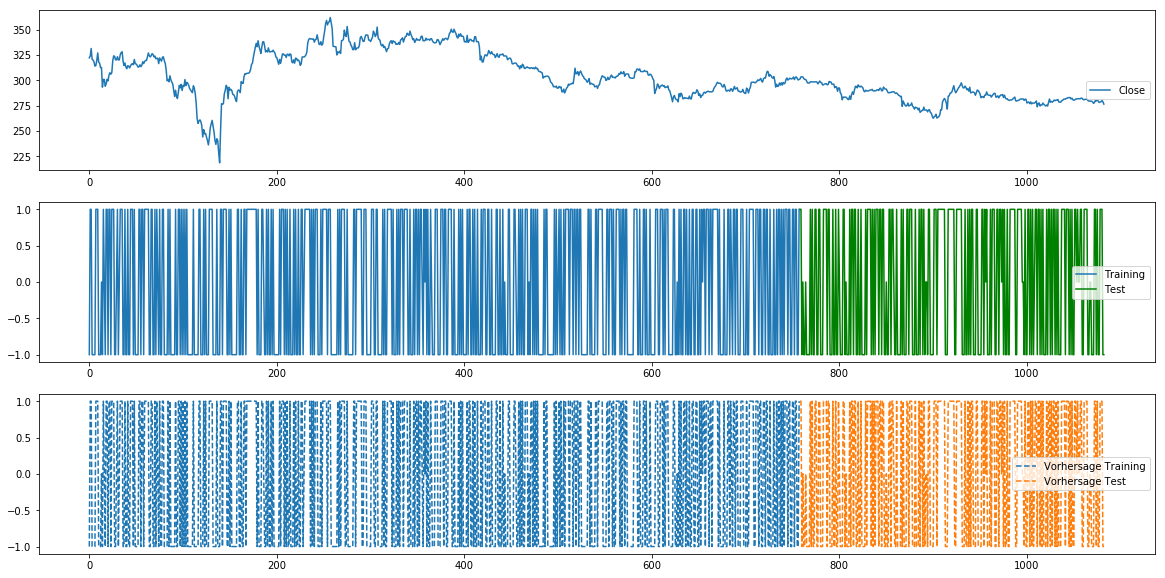

In [85]:
pipe.fit(X_test,y_test)
y_pred = pipe.predict(X_test)
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)

plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(range(0, len(y_test) + n_train), dash['Close'] , label="Close")
 
plt.legend(loc=('right'))
plt.subplot(312)
plt.plot(range(n_train), y_train, '-',label="Training")
plt.plot(range(n_train, len(y_test) + n_train), y_test, 'g-', label="Test")
plt.legend(loc=('right'))
plt.subplot(313)
plt.plot(range(n_train), y_pred_train, '--', label="Vorhersage Training")
plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Vorhersage Test")
plt.legend(loc=('right'))

In [17]:
import time
start_date = pd.Timestamp('2017-10-27')
test_vector_down = [281.11,284.50,274.70,279.50,8830,4338.79]
test_vector_up = [129.86,140.46,129.25,140.46,1169,1711.04]

In [18]:
print(pipe.predict(test_vector_up))
print(pipe.predict(test_vector_down))

[ 1.]
[ 1.]


/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1)